<a href="https://colab.research.google.com/github/ThePituLegend/RISCV-MISE/blob/main/UP_UC_amb_Muxes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EJEMPLO: UNIDAD DE PROCESO CON MULTIPLEXORES




Se desea realizar el cálculo
$$𝑂𝑈𝑇=𝑋^2*𝑌^2+𝑍^2+𝑊^2$$
donde *X*, *Y*, *Z*, *W* son números naturales (enteros y positivos) de como máximo 32 bits. Para mayor simplicidad, se supone que los resultados de las distintas operaciones se truncan a 32 bits, lo que supone mantener la salida *OUT* con el mismo número de bits (32) que las entradas.

>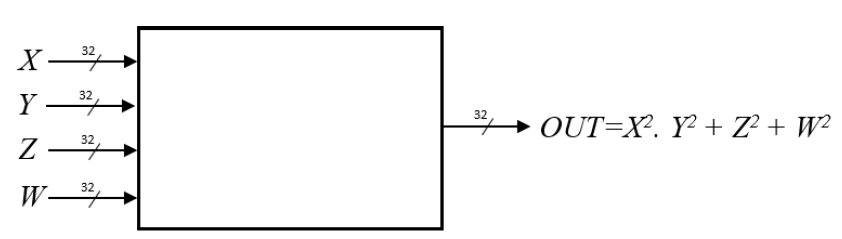

##0. Preparativos para simular

Para simular este circuito, emplearemos unos scripts de Python que podéis ejecutar desde esta página.

In [1]:
#@title Ajustes del *Notebook*

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'all'

In [2]:
#@title Cargar la librería *nbwavedrom*

!pip install nbwavedrom
from nbwavedrom import draw

In [3]:
#@title Cargar la librería *Py4Hw*

!git clone https://github.com/ThePituLegend/py4hw
%cd /content/py4hw
from py4hw import *

fatal: destination path 'py4hw' already exists and is not an empty directory.
/content/py4hw


In [4]:
#@title Creamos algunos módulos HW necesarios para el ejercicio

class RegSR(Logic):
    """
    This is a D flip flop + Set/Reset feature
    """

    def __init__(self, parent, name:str, d:Wire, e:Wire, q:Wire, s:Wire, r:Wire, sVal:int = 0):
        super().__init__(parent, name)
        self.d = self.addIn("d", d)
        self.e = self.addIn("e", e)
        self.q = self.addOut("q", q)
        self.s = self.addIn("s", s)
        self.r = self.addIn("r", r)
        self.value = 0
        
        if (sVal > 0 and d.getWidth() < int(log2(sVal))+1):
            raise Exception('Invalid set value')

        sValWire = Wire(self, "setValue", 1)
        zero = Wire(self, "zero", 1)
        muxToMux = Wire(self, "muxToMux", self.d.getWidth())
        muxToReg = Wire(self, "muxToReg", self.d.getWidth())
        orWire = Wire(self, "orWire", 1)
        eWire = Wire(self, "enable", 1)

        Constant(self, "setValue", sVal, sValWire)
        Constant(self, "0", 0, zero)
    
        self.muxS = Mux2(self, "muxS", s, d, sValWire, muxToMux)
        self.muxR = Mux2(self, "muxr", r, muxToMux, zero, muxToReg)

        Or(self, "or0", s, r, orWire)
        Or(self, "or1", orWire, e, eWire)

        self.reg = Reg(self, "reg", muxToReg, eWire, q)

## 1. Unidad de Proceso

Vamos a suponer que contamos con un <ins>único recurso de cálculo S/M</ins>, capaz de sumar o multiplicar dos números de n bits de acuerdo con una señal de control, *sm*, que define qué operación se realiza (suma cuando *sm*=0 y multiplica cuando *sm*=1).

>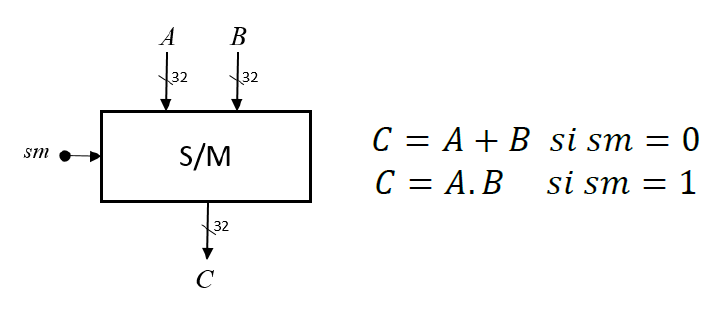

A continuación, tenéis el código que simulará este recurso:

In [5]:
class SM(Logic):
    """
    Configurable Incrementer/Multiplyer

    a+b if sel = 1
    a+1 if sel = 0
    """

    def __init__(self, parent, name: str, a: Wire, b: Wire, sel: Wire, r: Wire):
        super().__init__(parent, name)
        self.a = self.addIn("A", a)
        self.b = self.addIn("B", b)
        self.sel = self.addIn("SM", sel)
        
        self.c = self.addOut("C", r)
        
        o_s = Wire(self, "sumOut", b.getWidth())
        o_m = Wire(self, "mulOut", b.getWidth())

        self.add = Add(self, "add", a, b, o_s)
        self.mul = Mul(self, "mul", a, b, o_m)
        self.mux = Mux2(self, "mux", sel, o_s, o_m, self.c)
    
    def schematic(self):
      Schematic(self)

Las entradas a los registros Reg1 y Reg2 vienen siempre del módulo S/M, con lo cual conectaremos directamente la salida de S/M a la entrada de ambos registros. Las entradas al módulo S/M, sin embargo, varían en cada uno de los ciclos de reloj. Como hay 5 posibles configuraciones de entrada, añadiremos un multiplexor 8 a 1 de 32 bits en cada una de las entradas al módulo S/M de modo que, dependiendo del valor que tomen las señales se_SM (seleccionar entrada a S/M) lleguen al módulo S/M las entradas correspondientes a cada ciclo de reloj. La Unidad de Control, que todavía no hemos estudiado, será la encargada de generar los valores adecuados de se_SM en cada ciclo.

>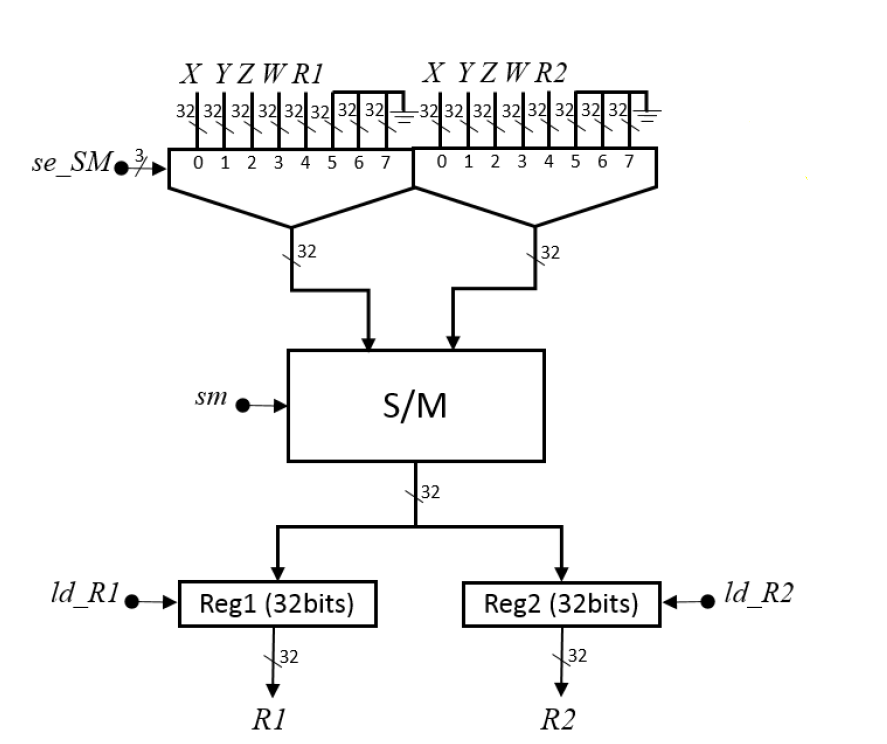

Los datos X, Y, Z, W llegan de registros situados en el exterior. Las salidas de R1 y R2 se conectan “por nombre” a las entradas número 4 de los multiplexores.
La señal se_SM (3 bits) indica en cada momento cuáles son las entradas que está recibiendo el módulo S/M; sm indica la operación que se está realizando, y las señales ld_R1 y ld_R2 son señales de carga síncrona de los registros Reg1 y Reg2 respectivamente. Todas estas señales recibirán, a partir de ahora, el nombre genérico de señales de control o, como veremos más adelante, microórdenes.

Puesto que el esquema anterior contiene todos los elementos que nos permitirán realizar el “proceso” (cálculo) deseado, le daremos el nombre de Unidad de Proceso:

>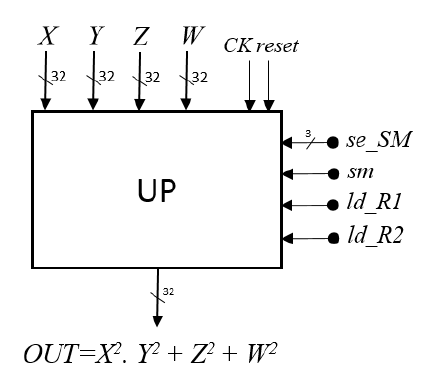

A continuación, tenéis el código que simulará la unidad de proceso (CK es implícito):

In [10]:
class ProcUnit(Logic):
    """
    Processing Unit for sqrt().
    """
    def __init__(self, parent, name:str, X:Wire, Y:Wire, Z:Wire, W:Wire,
                 se_SM:Wire, sm:Wire, ld_R1:Wire, ld_R2:Wire,
                 OUT:Wire):
        super().__init__(parent, name)

        # Init
        self.X = self.addIn(X.name, X)
        self.Y = self.addIn(Y.name, Y)
        self.Z = self.addIn(Z.name, Z)
        self.W = self.addIn(W.name, W)
        self.se_SM = self.addIn(se_SM.name, se_SM)
        self.sm = self.addIn(sm.name, sm)
        self.ld_R1 = self.addIn(ld_R1.name, ld_R1)
        self.ld_R2 = self.addIn(ld_R2.name, ld_R2)

        self.OUT = self.addOut(OUT.name, OUT)
       
        # Wires (The ones we want to draw will remain as attributes)
        lMuxOut = Wire(self, "lMuxOut", 32)
        rMuxOut = Wire(self, "rMuxOut", 32)
        smOut = Wire(self, "smOut", 32)
        R2Out = Wire(self, "R2Out", 32)

        zero = Wire(self, "zero", 1)

        # Constants
        Constant(self, "0", 0, zero)

        # Muxes
        self.lMux = Mux(self, "lMux", se_SM, [X, Y, Z, W, OUT, zero, zero, zero], lMuxOut)
        self.rMux = Mux(self, "rMux", se_SM, [X, Y, Z, W, R2Out, zero, zero, zero], rMuxOut)

        # Compute resource
        self.smModule = SM(self, "S/M", lMuxOut, rMuxOut, sm, smOut)

        # Registers
        self.R1 = Reg(self, "R1", smOut, ld_R1, OUT)
        self.R2 = Reg(self, "R2", smOut, ld_R2, R2Out)
    
    def schematic(self):
      Schematic(self)

## 2. Unidad de Control


***Insertar explicación y dibujos***


>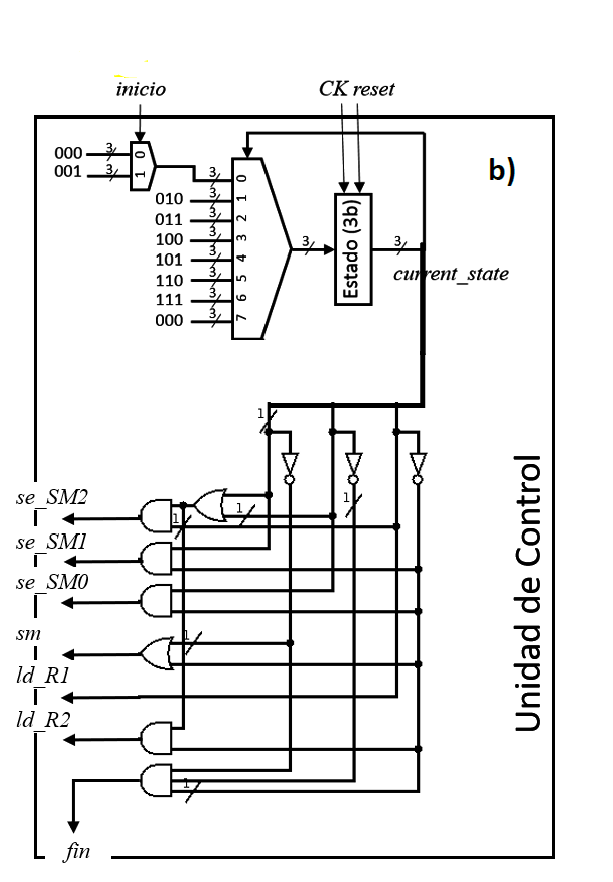

A continuación, tenéis el código que simulará la unidad de control:

In [7]:
class CtrlUnit(Logic):
    """
    Control Unit for sqrt().
    """
    def __init__(self, parent, name:str, inicio:Wire, 
                 se_SM:Wire, sm:Wire, ld_R1:Wire, ld_R2:Wire,
                 fin:Wire):
        super().__init__(parent, name)

        # Init
        self.inicio = self.addIn(inicio.name, inicio)

        self.se_SM = self.addOut(se_SM.name, se_SM)
        self.sm = self.addOut(sm.name, sm)
        self.ld_R1 = self.addOut(ld_R1.name, ld_R1)
        self.ld_R2 = self.addOut(ld_R2.name, ld_R2)
        self.fin = self.addOut(fin.name, fin)
        
        # Wires (The ones we want to draw will remain as attributes)
        self.current_state = self.wire("CurrentState", 3)

        mid_se_SM = self.wire("mid_se_SM")
        mid_fin = self.wire("mid_fin")
        
        startOut = self.wire("startOut", 3)
        muxOut = self.wire("MuxOut", 3)
        
        eWire = self.wire("enableWire", 1)

        # Constants
        self.one = Constant(self, "one", 1, eWire)

        # Wire Bundles
        se_SMBits = self.wires("se_SMBits", 3, 1)

        state_wires = self.wires("state_wire", 8, 3)
        for i, wire in enumerate(state_wires):
            Constant(self, f"{i:b}", i, wire)

        q = self.wires("q", 3, 1)
        q_not = self.wires("qNot", 3, 1)
        Bits(self, "state2q", self.current_state, q)
        for i, wire in enumerate(q):
            Not(self, f"not{i}", wire, q_not[i])

        # Muxes
        startMux = Mux2(self, "startMux", inicio, 
            state_wires[0b000], state_wires[0b001], startOut)

        muxIn = [startOut,
                state_wires[0b010],
                state_wires[0b011],
                state_wires[0b100],
                state_wires[0b101],
                state_wires[0b110],
                state_wires[0b111],
                state_wires[0b000]]
        mux = Mux(self, "MainMux", self.current_state, muxIn, muxOut)

        # Registers
        state_reg = Reg(self, "Estado", muxOut, eWire, self.current_state)

        # Logic Gates
        Or(self, "mid_se_SM0", q[2], q[1], mid_se_SM)
        And(self, "se_SM2_0", mid_se_SM, q[0], se_SMBits[0])

        And(self, "se_SM1_0", q[2], q_not[0], se_SMBits[1])

        And(self, "se_SM0_0", q[1], q_not[0], se_SMBits[2])

        Or(self, "sm0", q_not[2], q_not[0], sm)

        Repeat(self, "ld_R1_0", q[0], ld_R1)

        And(self, "ld_R2_0", mid_se_SM, q_not[0], ld_R2)

        And(self, "fin0", q_not[2], q_not[1], mid_fin)
        And(self, "fin1", mid_fin, q_not[0], fin)

        # se_SM concatenation
        Concatenate(self, "concat", se_SMBits, se_SM)


    def schematic(self):
       Schematic(self)

## 3. TestBench

In [20]:
sys = HWSystem()

X = sys.wire("X", 32)
Y = sys.wire("Y", 32)
Z = sys.wire("Z", 32)
W = sys.wire("W", 32)
OUT = sys.wire("OUT", 32)

se_SM = sys.wire("se_SM", 3)
sm = sys.wire("sm")
ld_R1 = sys.wire("ld_R1")
ld_R2 = sys.wire("ld_R2")

inicio = sys.wire("inicio")
fin = sys.wire("fin")

Constant(sys, "X", 2, X)
Constant(sys, "Y", 4, Y)
Constant(sys, "Z", 8, Z)
Constant(sys, "W", 10, W)

Constant(sys, "1", 1, inicio)

proc = ProcUnit(sys, "UP", X, Y, Z, W, se_SM, sm, ld_R1, ld_R2, OUT)
ctrl = CtrlUnit(sys, "UC", inicio, se_SM, sm, ld_R1, ld_R2, fin)

current_state_wf = Waveform(sys, "State", ctrl.current_state)
out_wf = Waveform(sys, "OUT", OUT)
fin_wf = Waveform(sys, "fin", fin)
se_SM_wf = Waveform(sys, "se_SM", se_SM)
sm_wf = Waveform(sys, "sm", sm)
ld_R1_wf = Waveform(sys, "ld_R1", ld_R1)
ld_R2_wf = Waveform(sys, "ld_R2", ld_R2)

#py4hw.debug.printHierarchyWithValues(sys)

sim = sys.getSimulator()

for _ in range(8):
  sim.clk(1)

draw(sim.get_waveform("Cronograma"))

placeInstances <__main__.SM object at 0x7f95a937a190>
child <py4hw.logic.Add object at 0x7f95a9320a10>
getSymbol -> good <py4hw.logic.Add object at 0x7f95a9320a10>
adding inport  <py4hw.logic.Add object at 0x7f95a9320a10> a
adding inport  <py4hw.logic.Add object at 0x7f95a9320a10> b
adding outport  <py4hw.logic.Add object at 0x7f95a9320a10> r
child <py4hw.logic.Mul object at 0x7f95a9320b10>
getSymbol -> none for object <class 'py4hw.logic.Mul'>
adding inport  <py4hw.logic.Mul object at 0x7f95a9320b10> a
adding inport  <py4hw.logic.Mul object at 0x7f95a9320b10> b
adding outport  <py4hw.logic.Mul object at 0x7f95a9320b10> r
child <py4hw.logic.Mux2 object at 0x7f95a9320c10>
getSymbol -> none for object <class 'py4hw.logic.Mux2'>
adding inport  <py4hw.logic.Mux2 object at 0x7f95a9320c10> sel
adding inport  <py4hw.logic.Mux2 object at 0x7f95a9320c10> sel0
adding inport  <py4hw.logic.Mux2 object at 0x7f95a9320c10> sel1
adding outport  <py4hw.logic.Mux2 object at 0x7f95a9320c10> r
iter 3 cost

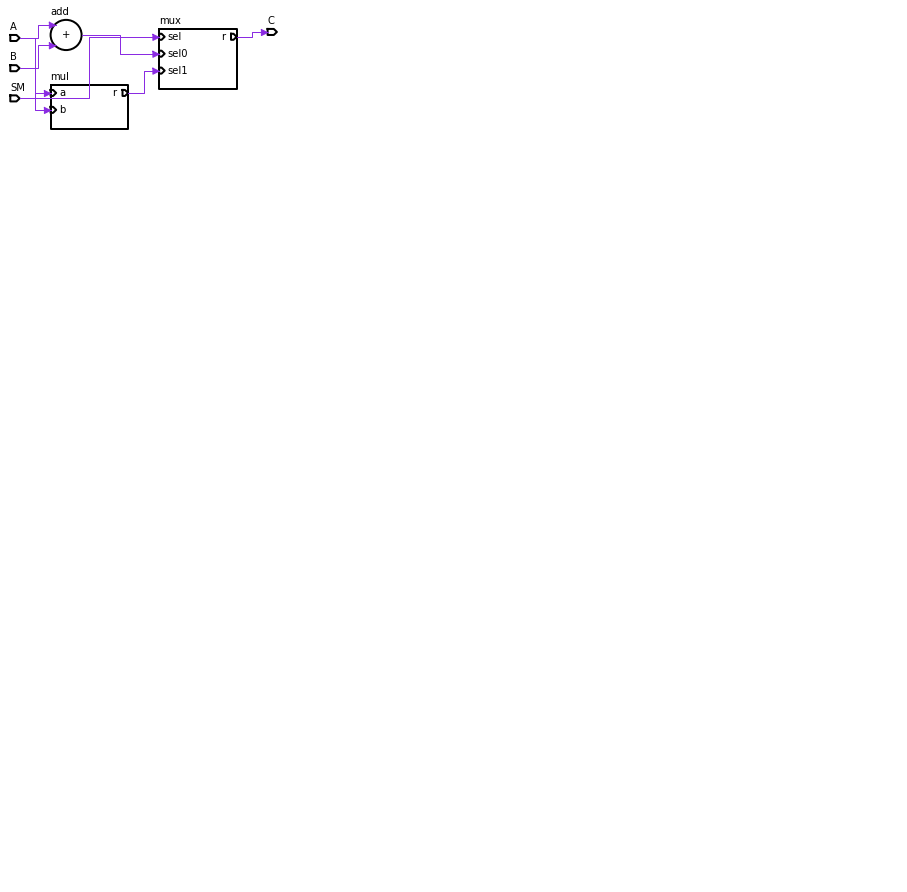

In [16]:
proc.smModule.schematic()

placeInstances <__main__.ProcUnit object at 0x7f95a95ab590>
child <py4hw.logic.Constant object at 0x7f95a937a3d0>
getSymbol -> none for object <class 'py4hw.logic.Constant'>
adding outport  <py4hw.logic.Constant object at 0x7f95a937a3d0> r
child <py4hw.logic.Mux object at 0x7f95a937a790>
getSymbol -> none for object <class 'py4hw.logic.Mux'>
adding inport  <py4hw.logic.Mux object at 0x7f95a937a790> sel
adding inport  <py4hw.logic.Mux object at 0x7f95a937a790> in0
adding inport  <py4hw.logic.Mux object at 0x7f95a937a790> in1
adding inport  <py4hw.logic.Mux object at 0x7f95a937a790> in2
adding inport  <py4hw.logic.Mux object at 0x7f95a937a790> in3
adding inport  <py4hw.logic.Mux object at 0x7f95a937a790> in4
adding inport  <py4hw.logic.Mux object at 0x7f95a937a790> in5
adding inport  <py4hw.logic.Mux object at 0x7f95a937a790> in6
adding inport  <py4hw.logic.Mux object at 0x7f95a937a790> in7
adding outport  <py4hw.logic.Mux object at 0x7f95a937a790> r
child <py4hw.logic.Mux object at 0x7f

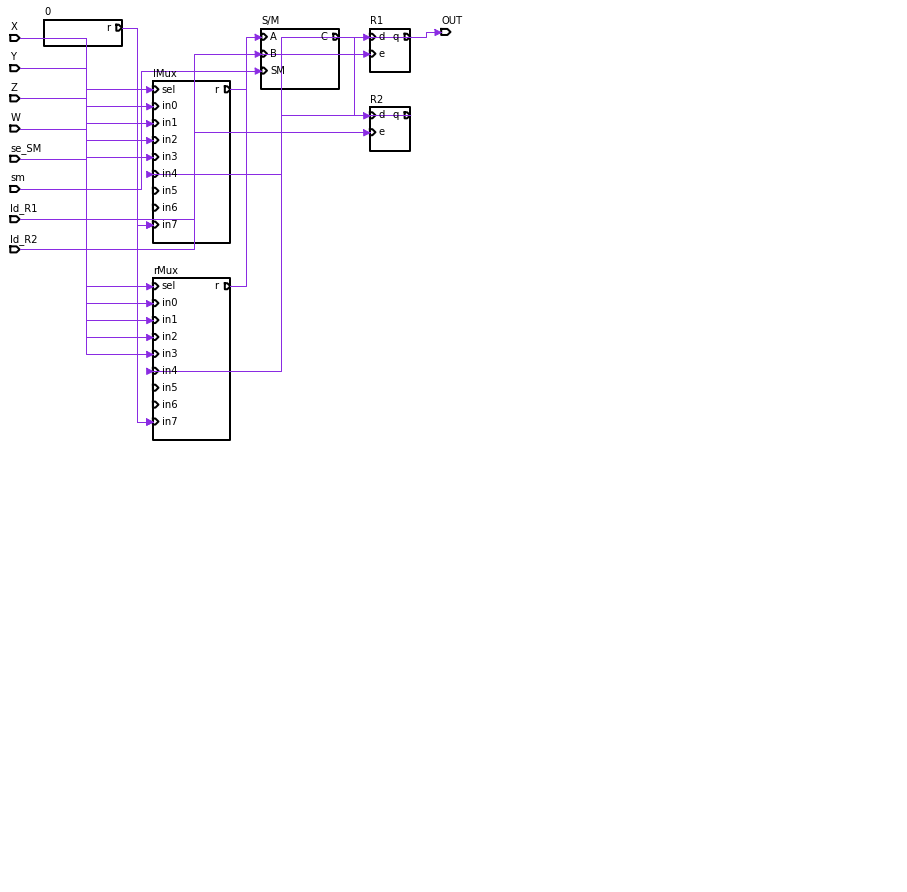

In [17]:
proc.schematic()

placeInstances <__main__.CtrlUnit object at 0x7f95a9313f10>
child <py4hw.logic.Constant object at 0x7f95a9347350>
getSymbol -> none for object <class 'py4hw.logic.Constant'>
adding outport  <py4hw.logic.Constant object at 0x7f95a9347350> r
child <py4hw.logic.Constant object at 0x7f95a93479d0>
getSymbol -> none for object <class 'py4hw.logic.Constant'>
adding outport  <py4hw.logic.Constant object at 0x7f95a93479d0> r
child <py4hw.logic.Constant object at 0x7f95a9347a50>
getSymbol -> none for object <class 'py4hw.logic.Constant'>
adding outport  <py4hw.logic.Constant object at 0x7f95a9347a50> r
child <py4hw.logic.Constant object at 0x7f95a9347b10>
getSymbol -> none for object <class 'py4hw.logic.Constant'>
adding outport  <py4hw.logic.Constant object at 0x7f95a9347b10> r
child <py4hw.logic.Constant object at 0x7f95a9347bd0>
getSymbol -> none for object <class 'py4hw.logic.Constant'>
adding outport  <py4hw.logic.Constant object at 0x7f95a9347bd0> r
child <py4hw.logic.Constant object at 0x

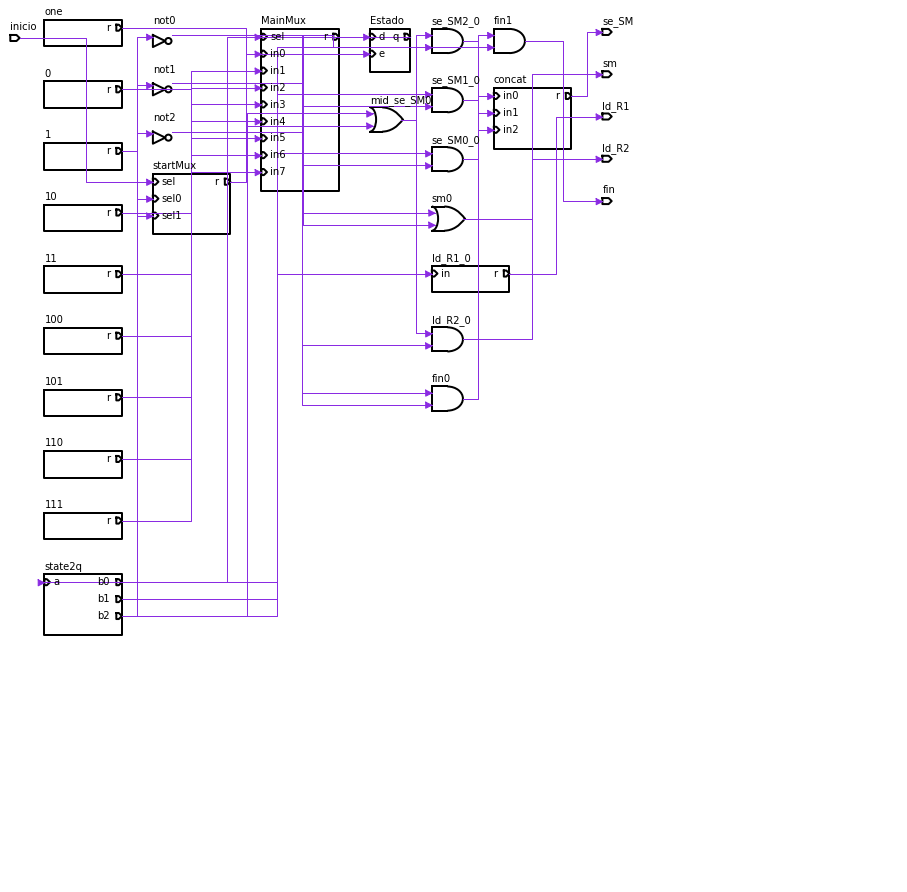

In [19]:
ctrl.schematic()